In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import matplotlib.animation as animation

In [53]:
data = np.load(r'D:\HaAnh\AimCLR-v2-main\data_cobot_clr_zoom\xsub\train_position.npy')

In [54]:
data.shape

(1481, 60, 48, 3)

In [55]:
data = data[1000]

In [56]:
data.shape 

(60, 48, 3)

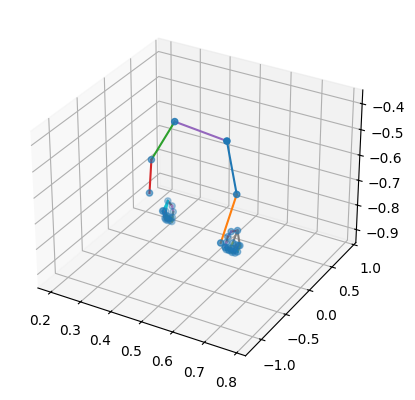

In [57]:
skeletonConnectionMap = [
    [42, 44], 
    [44, 46],
    [43, 45], 
    [45, 47],
    [42, 43],

    [0, 1], [1,2] ,[2,3], [3,4],
    [0, 5], [5,6], [6,7], [7,8],
    [9,10], [10,11], [11,12],
    [13,14], [14,15], [15,16],
    [0,17], [17,18], [18,19], [19,20],

    [21, 22], [22, 23], [23, 24], [24, 25],
    [21, 26], [26, 27], [27, 28], [28, 29],
    [30, 31], [31, 32], [32, 33],
    [34, 35], [35, 36], [36, 37],
    [21, 38], [38, 39], [39, 40], [40, 41]

    ]


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def visualize(data, nframe):

    x = data[nframe, :, 0]
    y = data[nframe, :, 2]
    z = data[nframe, :, 1]*(-1)

    lines=[]
    for connection in skeletonConnectionMap:
        i, j = connection
        line, = ax.plot(
            [data[nframe,i,0], data[nframe, j, 0]],
            [data[nframe,i,2], data[nframe, j, 2]],
            [data[nframe,i,1]*(-1), data[nframe, j, 1]*(-1)],
        )
        lines.append(line)

    scat = ax.scatter(x,y,z)
    ax.set_xlim(np.min(x)-0.2, np.max(x)+0.2)
    ax.set_ylim(np.min(y)-1, np.max(y)+1)
    ax.set_zlim(np.min(z)-0.05, np.max(z)+0.05)

    return scat, lines

def update(nframe, data, scat, lines):
    # for each frame, update the data stored on each artist.
    x = data[nframe, :, 0]
    y = data[nframe, :, 2]
    z = data[nframe, :, 1]*(-1)
    # update the scatter plot:
    scat._offsets3d = (x, y, z)
    # update the line plot:
    for idx, (i, j) in enumerate(skeletonConnectionMap):
        lines[idx].set_data([x[i], x[j]], [y[i], y[j]])
        lines[idx].set_3d_properties([z[i], z[j]])

    return scat,lines

scat, lines = visualize(data,0)
ani = animation.FuncAnimation(fig, func=update, frames=data.shape[0], fargs=(data, scat, lines), interval=30)
ani.save('test_original.mp4')

plt.show()


In [29]:
print('Right wrist',data[0,47,2])
print('Left wrist', data[0,46,2])

print('Right wrist',data[0,0,2])
print('Left wrist', data[0,21,2])

Right wrist -0.26696694
Left wrist -0.26410204
Right wrist -1.4649339e-07
Left wrist 4.537819e-08


In [30]:
#data: (nframes, njoints, dim)
def shear(data_numpy, r=0.5):
    s1_list = [random.uniform(-r, r), random.uniform(-r, r), random.uniform(-r, r)]
    s2_list = [random.uniform(-r, r), random.uniform(-r, r), random.uniform(-r, r)]

    R = np.array([[1,          s1_list[0], s2_list[0]],
                  [s1_list[1], 1,          s2_list[1]],
                  [s1_list[2], s2_list[2], 1        ]])

    R = R.transpose()
    data_numpy = np.dot(data_numpy, R)
    return data_numpy

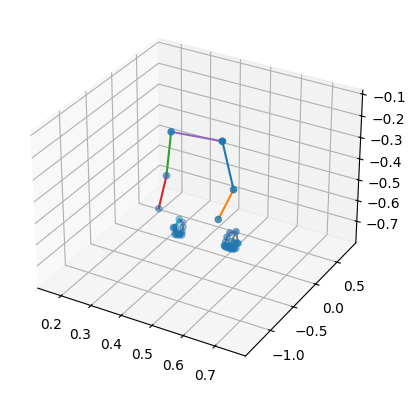

In [32]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
data_shear = shear(data)
scat, lines = visualize(data_shear,1)
ani2 = animation.FuncAnimation(fig, func=update, frames=60, fargs=(data_shear, scat, lines), interval=30)
ani2.save('aug_shear.mp4')

In [33]:
def temperal_crop(data_numpy, temperal_padding_ratio=6):
    T, _, _ = data_numpy.shape
    padding_len = T // temperal_padding_ratio
    frame_start = np.random.randint(0, padding_len * 2 + 1)
    data_numpy = np.concatenate((data_numpy[ :padding_len][ ::-1],
                                 data_numpy,
                                 data_numpy[-padding_len:][ ::-1]),
                                axis=0)
    data_numpy = data_numpy[frame_start:frame_start + T]
    return data_numpy

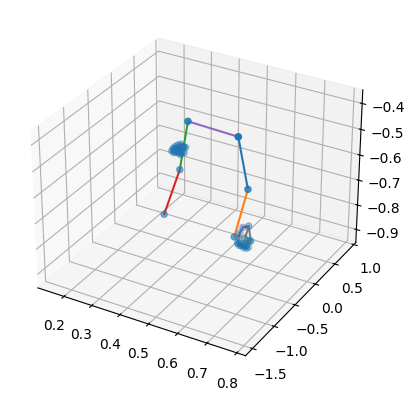

In [34]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
data_crop = temperal_crop(data)
scat, lines = visualize(data_crop,1)
ani2 = animation.FuncAnimation(fig, func=update, frames=60, fargs=(data_crop, scat, lines), interval=30)
ani2.save('aug_crop.mp4')

In [35]:
transform_order = {
    'cobot': [21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,43,42,45,44,47,46]
}
def random_spatial_flip(seq, p=0.5):
        # Do the left-right transform C,T,V,M
        index = transform_order['cobot']
        trans_seq = seq[ :, index, :]
        return trans_seq


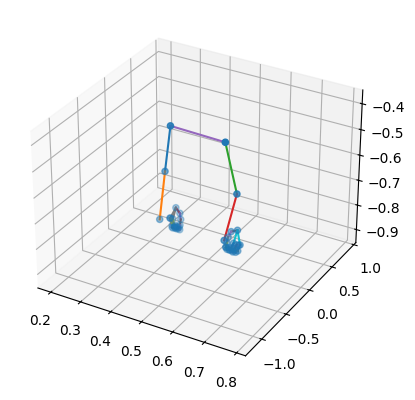

In [36]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
data_spatial_flip = random_spatial_flip(data)
scat, lines = visualize(data_spatial_flip ,1)
ani2 = animation.FuncAnimation(fig, func=update, frames=60, fargs=(data_spatial_flip , scat, lines), interval=30)
ani2.save('test_aug_spatial_flip.mp4')

In [37]:
def random_time_flip(seq):
    T = seq.shape[0]

    time_range_order = [i for i in range(T)]
    time_range_reverse = list(reversed(time_range_order))
    return seq[time_range_reverse, :, :]


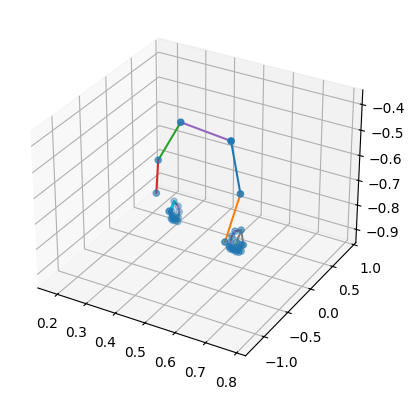

In [38]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
data_time_flip = random_time_flip(data)
scat, lines = visualize(data_time_flip ,1)
ani2 = animation.FuncAnimation(fig, func=update, frames=60, fargs=(data_time_flip , scat, lines), interval=30)
ani2.save('aug_time_flip.mp4')

In [39]:
import math
from math import sin, cos

def random_rotate(seq):
    def rotate(seq, axis, angle):
        # x
        if axis == 0:
            R = np.array([[1, 0, 0],
                              [0, cos(angle), sin(angle)],
                              [0, -sin(angle), cos(angle)]])
        # y
        if axis == 1:
            R = np.array([[cos(angle), 0, -sin(angle)],
                              [0, 1, 0],
                              [sin(angle), 0, cos(angle)]])

        # z
        if axis == 2:
            R = np.array([[cos(angle), sin(angle), 0],
                              [-sin(angle), cos(angle), 0],
                              [0, 0, 1]])
        R = R.T
        temp = np.matmul(seq, R)
        return temp

    new_seq = seq.copy()
    # C, T, V, M -> T, V, M, C
    #channel, nframe, njoint, maxbody
    # new_seq = np.transpose(new_seq, (1, 2, 3, 0))
    total_axis = [0, 1, 2]
    main_axis = random.randint(0, 2)
    for axis in total_axis:
        if axis == main_axis:
            rotate_angle = random.uniform(0, 30)
            rotate_angle = math.radians(rotate_angle)
            new_seq = rotate(new_seq, axis, rotate_angle)
        else:
            rotate_angle = random.uniform(0, 1)
            rotate_angle = math.radians(rotate_angle)
            new_seq = rotate(new_seq, axis, rotate_angle)

    # new_seq = np.transpose(new_seq, (3, 0, 1, 2))

    return new_seq

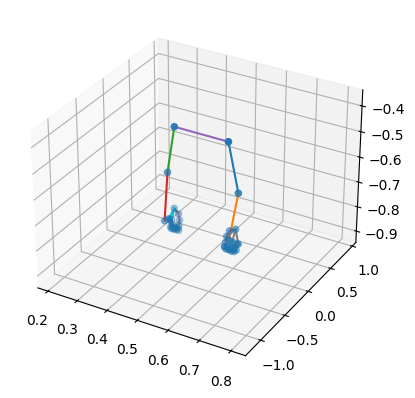

In [40]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
data_rotate = random_rotate(data)
scat, lines = visualize(data_rotate ,1)
ani2 = animation.FuncAnimation(fig, func=update, frames=60, fargs=(data_rotate , scat, lines), interval=30)
ani2.save('aug_rotate.mp4')

In [41]:
def gaus_noise(data_numpy, mean= 0, std=0.01, p=0.5):
        temp = data_numpy.copy()
        T, V, C = data_numpy.shape
        noise = np.random.normal(mean, std, size=(T, V, C))
        return temp + noise

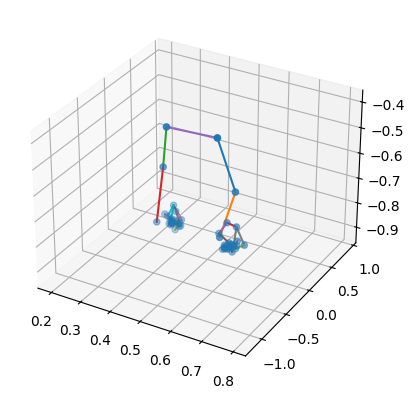

In [42]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
data_noise = gaus_noise(data)
scat, lines = visualize(data_noise ,1)
ani2 = animation.FuncAnimation(fig, func=update, frames=60, fargs=(data_noise , scat, lines), interval=30)
ani2.save('aug_noise.mp4')

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def gaus_filter(data_numpy):
    g = GaussianBlurConv(3)
    return g(data_numpy)


class GaussianBlurConv(nn.Module):
    def __init__(self, channels=3, kernel = 15, sigma = [0.1, 2]):
        super(GaussianBlurConv, self).__init__()
        self.channels = channels
        self.kernel = kernel
        self.min_max_sigma = sigma
        radius = int(kernel / 2)
        self.kernel_index = np.arange(-radius, radius + 1)

    def __call__(self, x):
        sigma = random.uniform(self.min_max_sigma[0], self.min_max_sigma[1])
        blur_flter = np.exp(-np.power(self.kernel_index, 2.0) / (2.0 * np.power(sigma, 2.0)))
        kernel = torch.from_numpy(blur_flter).unsqueeze(0).unsqueeze(0)
        # kernel =  kernel.float()
        kernel = kernel.double()
        kernel = kernel.repeat(self.channels, 1, 1, 1) # (3,1,1,5)
        self.weight = nn.Parameter(data=kernel, requires_grad=False).float()

        x = torch.from_numpy(x)
        x = x.permute(2, 0, 1) 
        x = x.unsqueeze(0) #(batch, frame, joint, chan)
        x = x.permute(0,1,3,2) # M,C,V,T  #batch, channel, joint, frame
        x = F.conv2d(x, self.weight, padding=(0, int((self.kernel - 1) / 2 )),   groups=self.channels)
        x = x.permute(0, 3,2, 1).squeeze(0) #C,T,V

        return x.numpy()

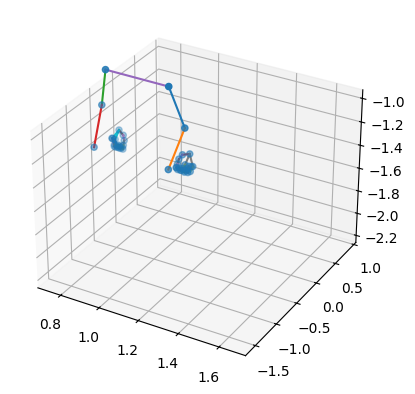

In [44]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
data_blur = gaus_filter(data)
scat, lines = visualize(data_blur ,1)
ani2 = animation.FuncAnimation(fig, func=update, frames=60, fargs=(data_blur , scat, lines), interval=30)
ani2.save('aug_blur.mp4')

In [45]:
class Zero_out_axis(object):
    def __init__(self, axis = None):
        self.first_axis = axis


    def __call__(self, data_numpy):
        if self.first_axis != None:
            axis_next = self.first_axis
        else:
            axis_next = random.randint(0,2)

        temp = data_numpy.copy()
        T, V, C = data_numpy.shape
        x_new = np.zeros((T, V))
        temp[:,:,axis_next] = x_new
        return temp

def axis_mask(data_numpy, p=0.5):
    am = Zero_out_axis()
    return am(data_numpy)

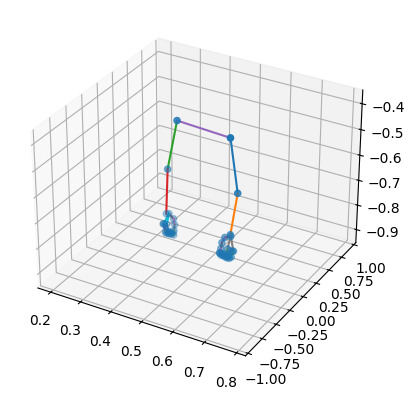

In [46]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
data_mask = axis_mask(data)
scat, lines = visualize(data_mask ,1)
ani2 = animation.FuncAnimation(fig, func=update, frames=60, fargs=(data_mask , scat, lines), interval=30)
ani2.save('aug_mask.mp4')

In [ ]:
def random_scale_2d(data_numpy, scale_range=(0.8, 1.2), p=0.5):
    """Scale the 2D skeleton uniformly or non-uniformly"""
    temp = data_numpy.copy()
    T, V, C = data_numpy.shape
    
    # Uniform scaling
    if random.random() < 0.5:
        scale = random.uniform(scale_range[0], scale_range[1])
        temp[:,:,0] *= scale  # X coordinates
        temp[:,:,1] *= scale  # Y coordinates
    else:
        # Non-uniform scaling (different for X and Y)
        scale_x = random.uniform(scale_range[0], scale_range[1])
        scale_y = random.uniform(scale_range[0], scale_range[1])
        temp[:,:,0] *= scale_x  # X coordinates
        temp[:,:,1] *= scale_y  # Y coordinates
    
    return temp

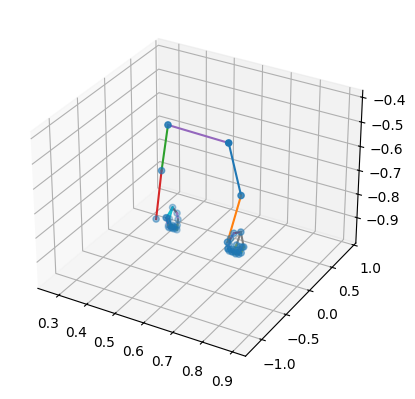

In [60]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
data_mask = random_scale_2d(data)
scat, lines = visualize(data_mask ,1)
ani2 = animation.FuncAnimation(fig, func=update, frames=60, fargs=(data_mask , scat, lines), interval=30)
ani2.save('aug_scale2d.mp4')

In [61]:
def random_translate_2d(data_numpy, translate_range=0.1, p=0.5):
    """Translate the 2D skeleton randomly"""
    temp = data_numpy.copy()
    T, V, C  = data_numpy.shape
    
    # Calculate translation based on data range
    x_range = np.ptp(temp[:,:,0])  # Peak-to-peak range
    y_range = np.ptp(temp[:,:,1])
    
    translate_x = random.uniform(-translate_range, translate_range) * x_range
    translate_y = random.uniform(-translate_range, translate_range) * y_range
    
    temp[:,:,0] += translate_x  # X coordinates
    temp[:,:,1] += translate_y  # Y coordinates
    
    return temp


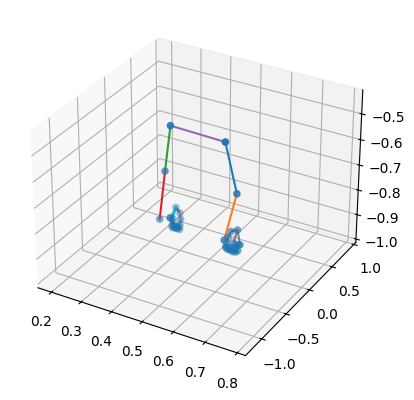

In [62]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
data_mask = random_translate_2d(data)
scat, lines = visualize(data_mask ,1)
ani2 = animation.FuncAnimation(fig, func=update, frames=60, fargs=(data_mask , scat, lines), interval=30)
ani2.save('aug_translate2d.mp4')

In [68]:
def random_joint_dropout_2d(data_numpy, dropout_joints=3, p=0.3):
    """Randomly dropout some joints (set to zero or interpolate)"""
    temp = data_numpy.copy()
    T, V, C = data_numpy.shape
    
    # Select random joints to dropout
    dropout_indices = random.sample(range(V), min(dropout_joints, V//4))
    
    for joint_idx in dropout_indices:
        if random.random() < 0.5:
            # Set to zero
            temp[:, joint_idx, :] = 0
        else:
            # Linear interpolation between neighboring frames
            for t in range(T):
                if t > 0 and t < T-1:
                    temp[t, joint_idx, :] = (temp[t-1, joint_idx, :] + temp[t+1, joint_idx, :]) / 2
    
    return temp


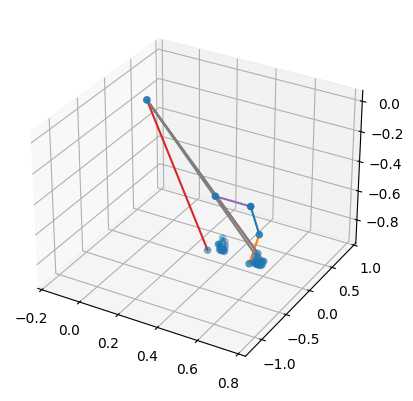

In [70]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
data_mask = random_joint_dropout_2d(data)
scat, lines = visualize(data_mask ,1)
ani2 = animation.FuncAnimation(fig, func=update, frames=60, fargs=(data_mask , scat, lines), interval=30)
ani2.save('aug_joint_dropout2d.mp4')

In [71]:
def random_hand_emphasis_2d(data_numpy, emphasis_factor=1.5, p=0.3):
    """Emphasize hand movements for hand-centric actions (COBOT specific)"""
    temp = data_numpy.copy()
    T,V,C = data_numpy.shape
    
    if V == 48:  # COBOT layout
        # Hand joints: 0-20 (right hand), 21-41 (left hand)
        hand_joints = list(range(21)) + list(range(21, 42))
        
        # Calculate center of mass for hands
        for joint_idx in hand_joints:
            # Emphasize relative movement from first frame
            baseline = temp[0:1, joint_idx:joint_idx+1, :2]  # First frame as baseline
            movement = temp[:, joint_idx:joint_idx+1, :2] - baseline
            temp[:, joint_idx:joint_idx+1, :2] = baseline + movement * emphasis_factor
    
    return temp


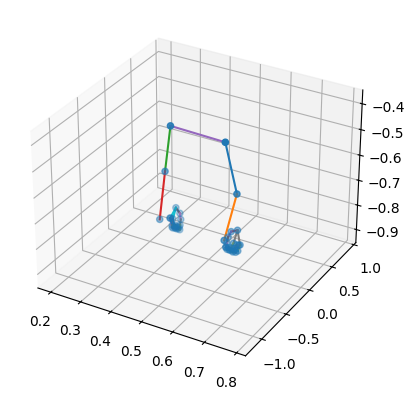

In [72]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
data_mask = random_hand_emphasis_2d(data)
scat, lines = visualize(data_mask ,1)
ani2 = animation.FuncAnimation(fig, func=update, frames=60, fargs=(data_mask , scat, lines), interval=30)
ani2.save('aug_hand_emphasis2d.mp4')